## FD_abs[hhb2] ANN Fitting

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import sys
! pip install pmcx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 48.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)

Mounted at /content/drive


In [11]:
from FD_msNIRS_2layers import extract_freq as ef

### Read Simulation data

In [3]:
import os
import pickle
import numpy as np

In [5]:
result_folder1 = '/content/drive/MyDrive/MCX_data/stage1_results/'
#result_folder2 = '/content/drive/MyDrive/MCX_data/result_folder/part2/'
#result_folder3 = '/content/drive/MyDrive/MCX_data/result_folder/part3/'
#result_folder4 = '/content/drive/MyDrive/MCX_data/result_folder/part4/'
#result_folder5 = '/content/drive/MyDrive/MCX_data/MCX_sim_data/1-4/Results/'
result_folders = [result_folder1]

In [13]:
def row_construct(dictt):
    re = np.zeros((1, 96))
    col = 0
    for k, v in dictt.items():  # four distances
        TPSF_list = v
        uac_i, udc_i, p1 = ef(1e6, TPSF_list, tend=1e-08, devf=1000)  # 8 wavelengths
        combined = []
        for i in range(8):
            combined.extend([uac_i[i], udc_i[i], p1[i]])  # Interleave the values
        re[0, col:col+24] = combined  # Each set contributes 24 values
        col += 24
    return re

In [12]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

def extract_id_from_path(path):
    filename = os.path.basename(path)
    return int(filename.replace('.pkl', ''))

def load_and_construct(path):
    with open(path, 'rb') as f:
        dictt = pickle.load(f)
    return row_construct(dictt)

def load_and_process_all(result_folders):
    # Collect all file paths
    file_paths = []
    for folder in result_folders:
        for f in os.listdir(folder):
            if f.endswith('.pkl'):
                file_paths.append(os.path.join(folder, f))

    # Sort by numeric filename
    sorted_paths = sorted(file_paths, key=extract_id_from_path)
    sorted_ids = [extract_id_from_path(p) for p in sorted_paths]

    # Load and process in parallel (with progress bar)
    all_rows = []
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_and_construct, sorted_paths), total=len(sorted_paths), desc="Loading and processing files"))

    result_array = np.vstack(results)
    return result_array, sorted_ids

In [14]:
final_array, sorted_ids = load_and_process_all(result_folders)

Loading and processing files: 100%|██████████| 2000/2000 [00:56<00:00, 35.23it/s]


In [15]:
final_array.shape

(2000, 96)

In [16]:
# Save to CSV
output_csv_path = '/content/drive/MyDrive/MCX_data/stage1.csv'
pd.DataFrame(final_array).to_csv(output_csv_path, index=False, header=False)

In [17]:
final_array.shape

(2000, 96)

### Read the saved CSV

In [1]:
import pandas as pd
import glob
import numpy as np
import sys
! pip install pmcx
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 40.3 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
csv_path = '/content/drive/MyDrive/MCX_data/stage1.csv'
final_array = np.loadtxt(csv_path, delimiter=',')
print(final_array.shape)
X = final_array

(2000, 96)


### GT

In [3]:
GT_folder = '/content/drive/MyDrive/MCX_data/stage1_csv/'

In [4]:
csv_files = glob.glob(os.path.join(GT_folder, '*.csv'))
GT_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

In [5]:
GT_all.head()

,HBO1,HHB1,HBO2,HHB2,d1,a1,a2,b1,b2,ID
0,8.801696,3.218081,29.967631,30.957545,11.0,3.171905,1.437481,2.281948,1.083814,251
1,16.301696,8.218081,44.967631,20.957545,16.0,6.171905,2.987481,1.081948,2.583814,252
2,14.426696,4.468081,48.717631,33.457545,20.0,5.421905,4.149981,1.981948,1.458814,253
3,6.926696,9.468081,33.717631,23.457545,15.0,2.421905,2.599981,0.781948,2.958814,254
4,18.176696,6.968081,41.217631,28.457545,12.0,0.921905,1.824981,1.381948,0.708814,255


In [6]:
sorted_ids = [i+1 for i in range(2000)]

In [7]:
sorted_ids[-1]

2000

In [8]:
# Ensure ID column is integer
GT_all['ID'] = GT_all['ID'].astype(int)

# Filter and sort GT_all to match the sorted_ids order
GT_filtered = GT_all[GT_all['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()

# Extract HHB2 as Y
Y = GT_filtered['HHB2'].values  # numpy array (n_samples,)
Y = Y.reshape(-1, 1)

In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Scale X
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

# Scale Y
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y)

In [10]:
X.shape

(2000, 96)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [12]:
print(X_train.shape, X_test.shape)

(1800, 96) (200, 96)


### ANN

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.losses import Huber
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential([
    Input(shape=(96,)),
    Dense(1000, activation='relu'),
    Dropout(0.1),

    Dense(4096, activation='relu'),
    Dropout(0.1),

    Dense(4096, activation='relu'),
    Dropout(0.2),

    Dense(8192, activation='relu'),
    Dropout(0.2),

    Dense(8192*2, activation='relu'),
    Dropout(0.2),

    Dense(8192, activation='relu'),
    Dropout(0.2),

    Dense(4096, activation='relu'),
    Dropout(0.2),

    Dense(2048, activation='relu'),
    Dropout(0.2),

    Dense(1024, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.1),

    Dense(256, activation='relu'),
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dropout(0.1),

    Dense(32, activation='relu'),
    Dropout(0.0),

    Dense(1)  # Output layer for regression
])


# 1) Create a checkpoint callback that saves the best model:
checkpoint_cb = ModelCheckpoint(
    "best_model.keras",        # filepath to save to
    monitor="val_loss",     # quantity to monitor
    mode="min",             # we want to minimize val_loss
    save_best_only=True,    # only save when val_loss decreases
    save_weights_only=False # set True if you only want weights
)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss="mse")

# 3) Fit with the checkpoint callback
history = model.fit(
    X_train, Y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint_cb]
)

# 4) Later on (or in a new script), load the best model:
model = tf.keras.models.load_model("best_model.keras")

Epoch 1/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 0.9943 - val_loss: 1.0239
Epoch 2/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 459ms/step - loss: 1.0055 - val_loss: 1.0234
Epoch 3/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9885 - val_loss: 1.0237
Epoch 4/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 441ms/step - loss: 0.9992 - val_loss: 1.0208
Epoch 5/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9724 - val_loss: 1.0211
Epoch 6/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 440ms/step - loss: 1.0223 - val_loss: 1.0150
Epoch 7/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9774 - val_loss: 1.0184
Epoch 8/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9732 - val_loss: 1.0245
Epoch 9/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 415ms/step - loss: 0.9760 - val_loss: 1.0119
Epoch 10/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 436ms/step - loss: 1.0019 - val_loss: 0.9854
Epoch 11/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9515 - val_loss: 1.0007
Epoch 12/300
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [14]:
# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Test MSE: 0.6539


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │        97,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │     4,100,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8192)           │    33,562,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16384)          │   134,234,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8192)           │   134,225,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,08

 Total params: 1,103,169,341 (4.11 GB)

 Trainable params: 367,723,113 (1.37 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 735,446,228 (2.74 GB)

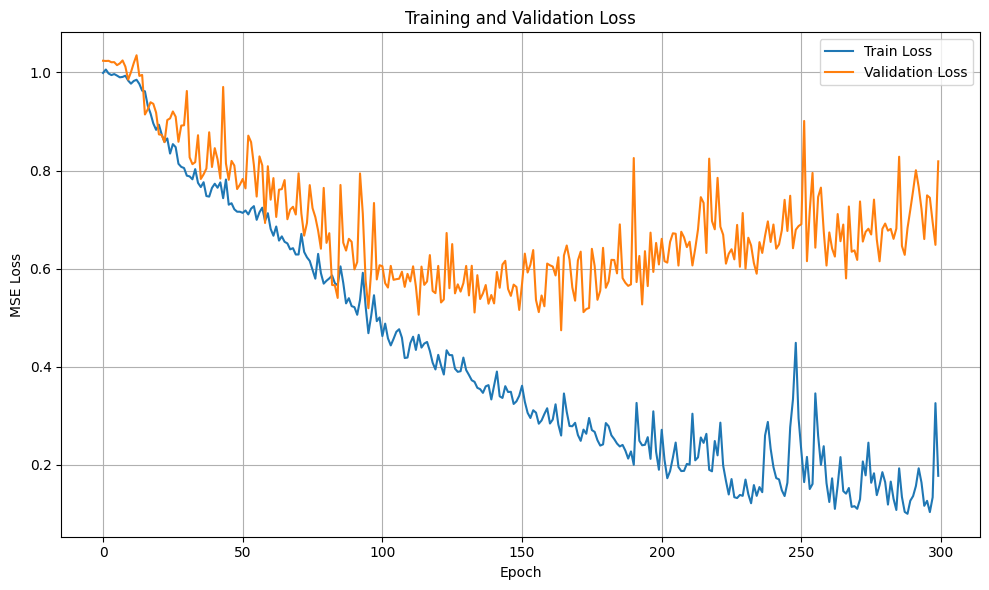

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Test MSE: 21.7992


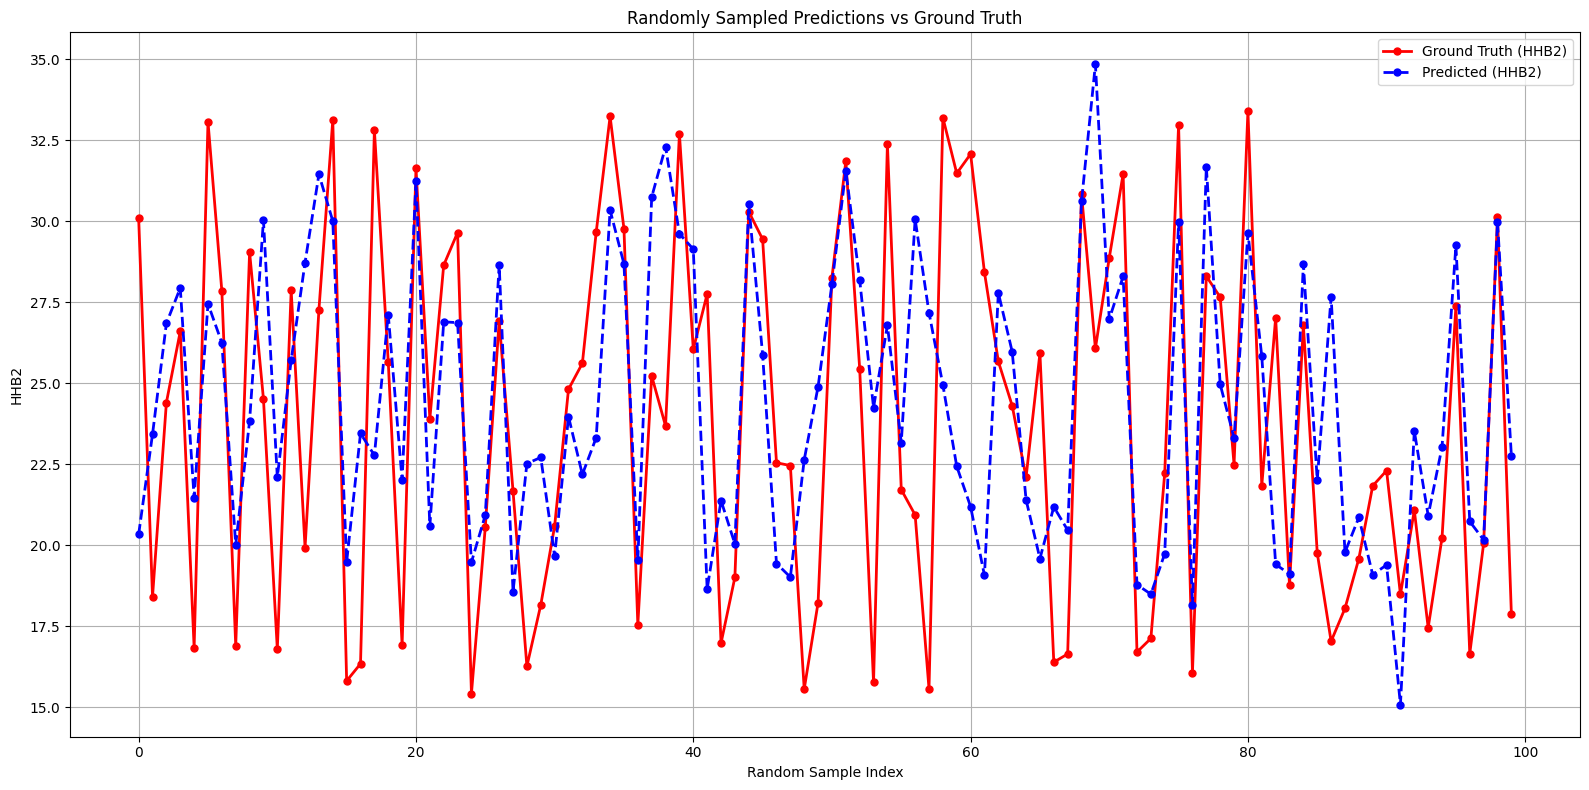

In [17]:
# Randomly select 100 indices
import matplotlib.pyplot as plt
indices = np.random.choice(len(Y_test), size=100, replace=False)
indices = np.sort(indices)

y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"Test MSE: {mse:.4f}")


# Extract corresponding values
y_test_sampled = y_test_rescaled[indices]
y_pred_sampled = y_pred_rescaled[indices]

# Plot with circular markers
plt.figure(figsize=(16, 8))
plt.plot(y_test_sampled, 'r-o', label='Ground Truth (HHB2)', linewidth=2, markersize=5)
plt.plot(y_pred_sampled, 'b--o', label='Predicted (HHB2)', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('HHB2')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Test MSE (original scale): 21.7992


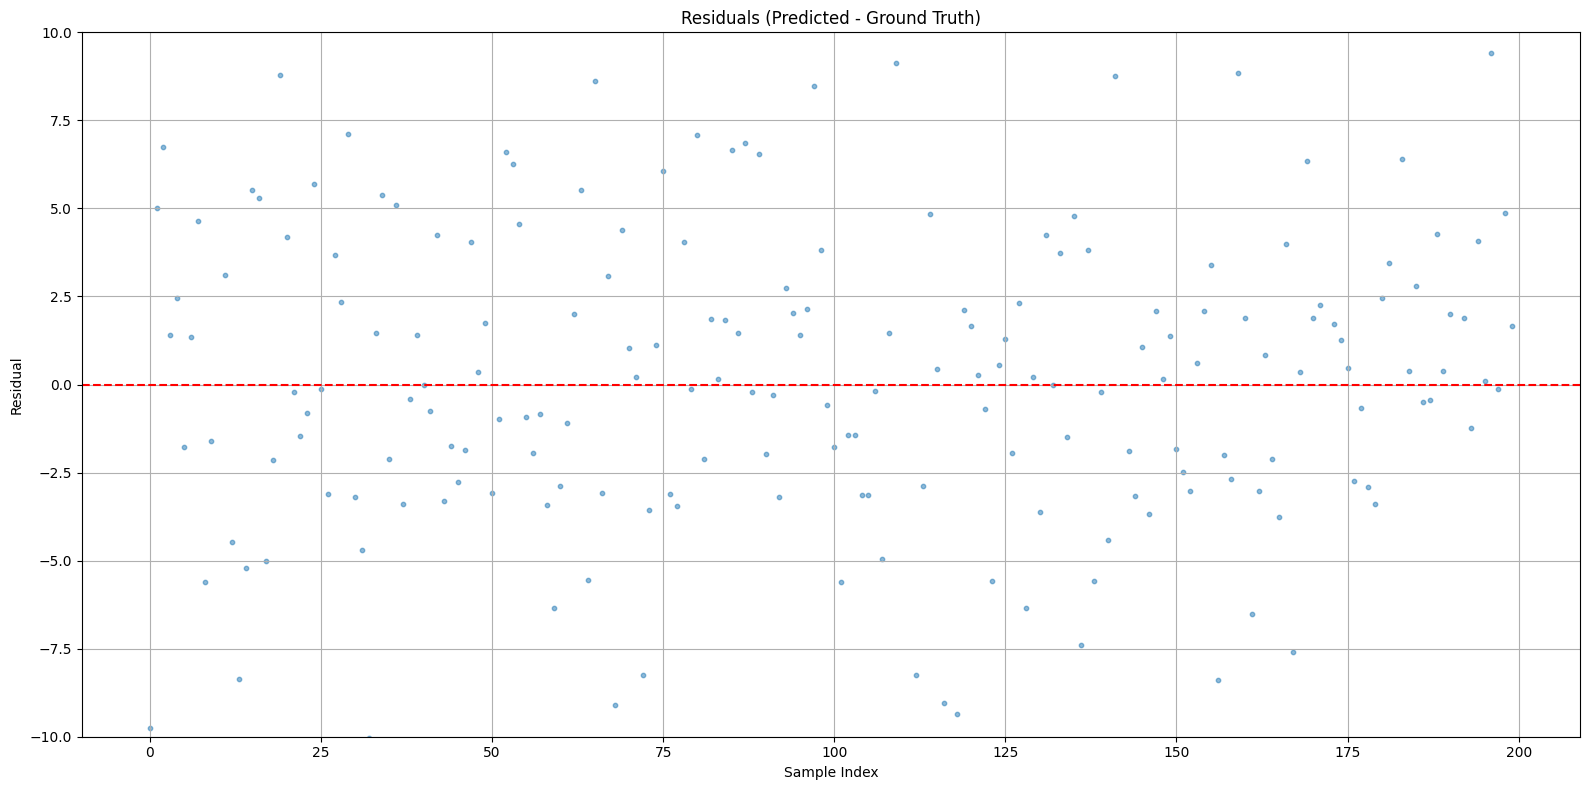

In [18]:
# Inverse-transform predictions and ground truth
y_pred_orig = scaler_y.inverse_transform(y_pred)       # shape (n, 1)
y_test_orig = scaler_y.inverse_transform(Y_test)     # shape (n, 1)

# Compute residuals in original scale
residuals = y_pred_orig - y_test_orig

mse_rescaled = mean_squared_error(y_test_orig, y_pred_orig)
print(f"Test MSE (original scale): {mse_rescaled:.4f}")

# Plot residuals
plt.figure(figsize=(16, 8))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (Predicted - Ground Truth)")
plt.ylabel("Residual")
plt.ylim(-10, 10)
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

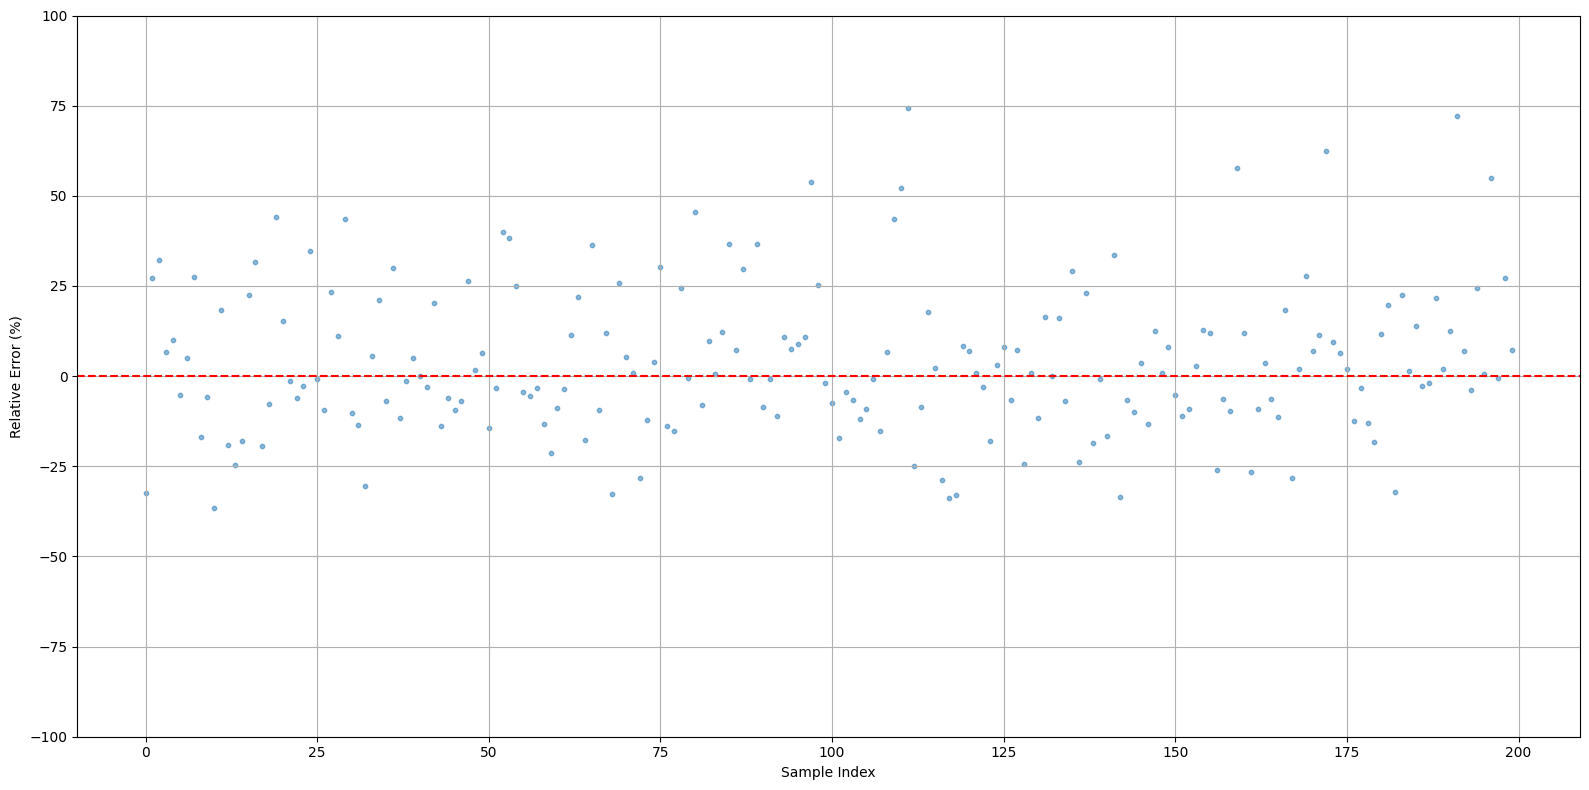

In [19]:
# Inverse-transform predictions and ground truth
y_pred_orig = scaler_y.inverse_transform(y_pred)       # shape (n, 1)
y_test_orig = scaler_y.inverse_transform(Y_test)     # shape (n, 1)

# Compute relative error (percentage)
relative_error = ((y_pred_orig - y_test_orig) / y_test_orig) * 100

# Plot relative error
plt.figure(figsize=(16, 8))
plt.scatter(range(len(relative_error)), relative_error, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.ylabel("Relative Error (%)")
plt.ylim(-100, 100)
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()


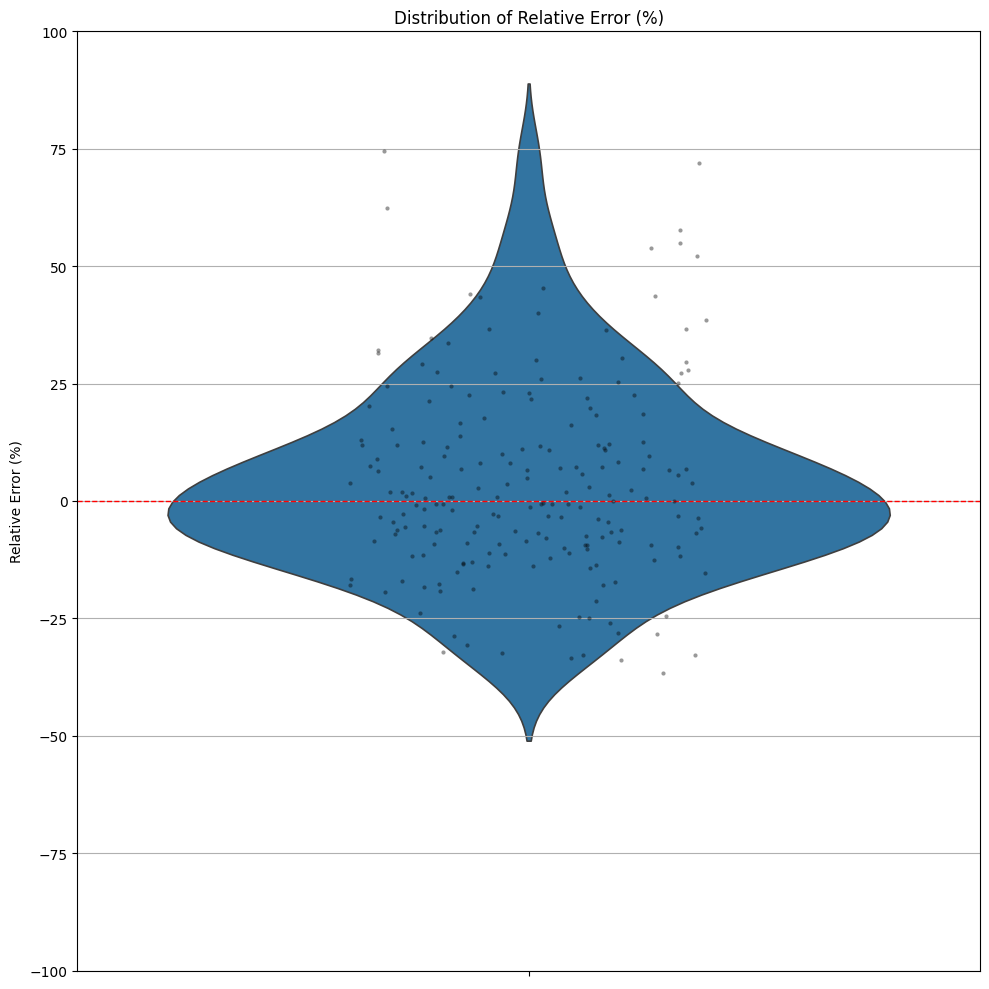

In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare DataFrame for seaborn
df_plot = pd.DataFrame({
    'Relative Error (%)': relative_error.flatten()
})

plt.figure(figsize=(10, 10))
sns.violinplot(data=df_plot, y='Relative Error (%)', inner=None, linewidth=1.2)
sns.stripplot(data=df_plot, y='Relative Error (%)', color='black', alpha=0.4, jitter=0.2, size=3)

plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.ylim(-100, 100)
plt.title('Distribution of Relative Error (%)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


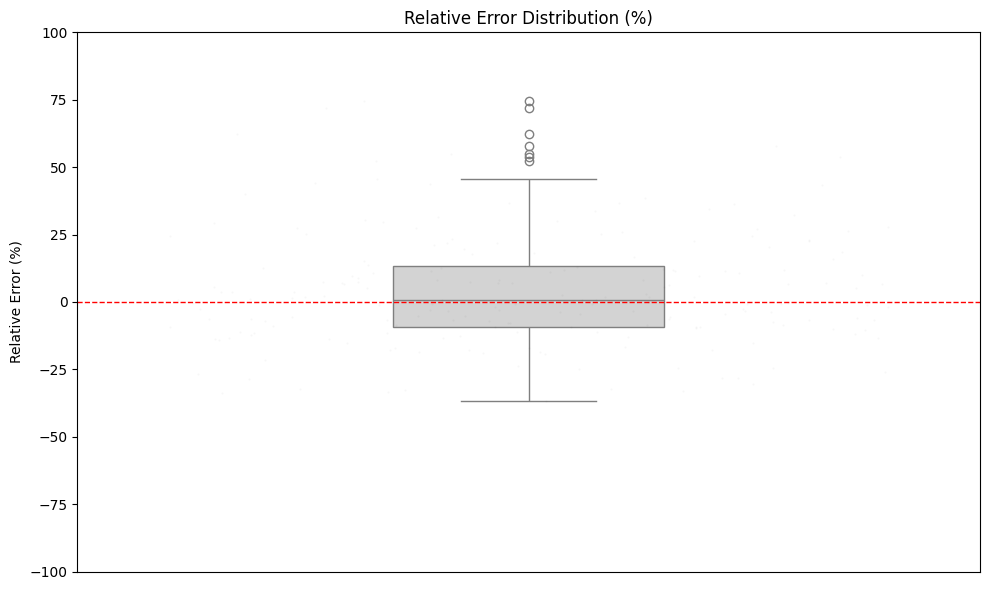

In [21]:
relative_error = relative_error.squeeze()

plt.figure(figsize=(10, 6))
sns.boxplot(y=relative_error, color='lightgray', width=0.3)
sns.stripplot(y=relative_error, color='black', alpha=0.03, jitter=0.4, size=1.5)

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Relative Error Distribution (%)')
plt.ylabel('Relative Error (%)')
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()


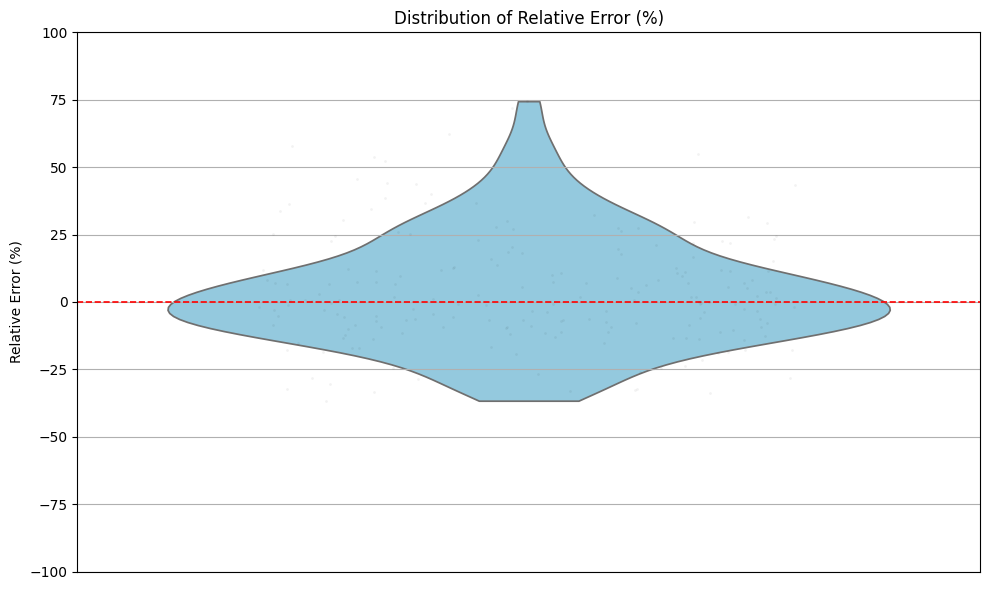

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))
sns.violinplot(y=relative_error, inner=None, color='skyblue', cut=0)
sns.stripplot(y=relative_error, color='black', alpha=0.05, jitter=0.3, size=2)

plt.axhline(0, color='red', linestyle='--', linewidth=1.2)
plt.title('Distribution of Relative Error (%)')
plt.ylabel('Relative Error (%)')
plt.grid()
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()


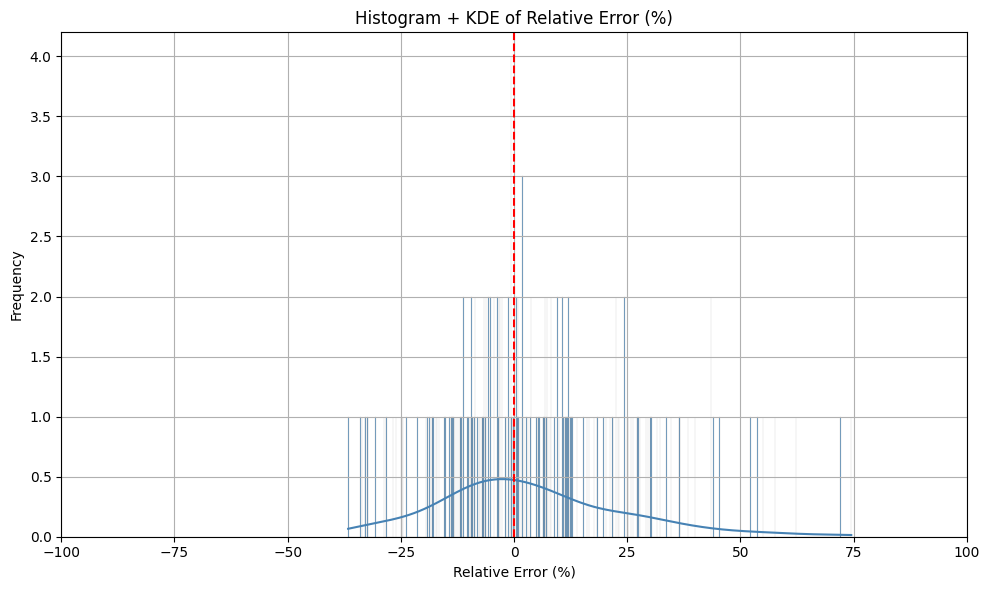

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(relative_error, kde=True, bins=1000, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram + KDE of Relative Error (%)")
plt.xlabel("Relative Error (%)")
plt.ylabel("Frequency")
plt.grid()
plt.xlim(-100, 100)
plt.tight_layout()
plt.show()

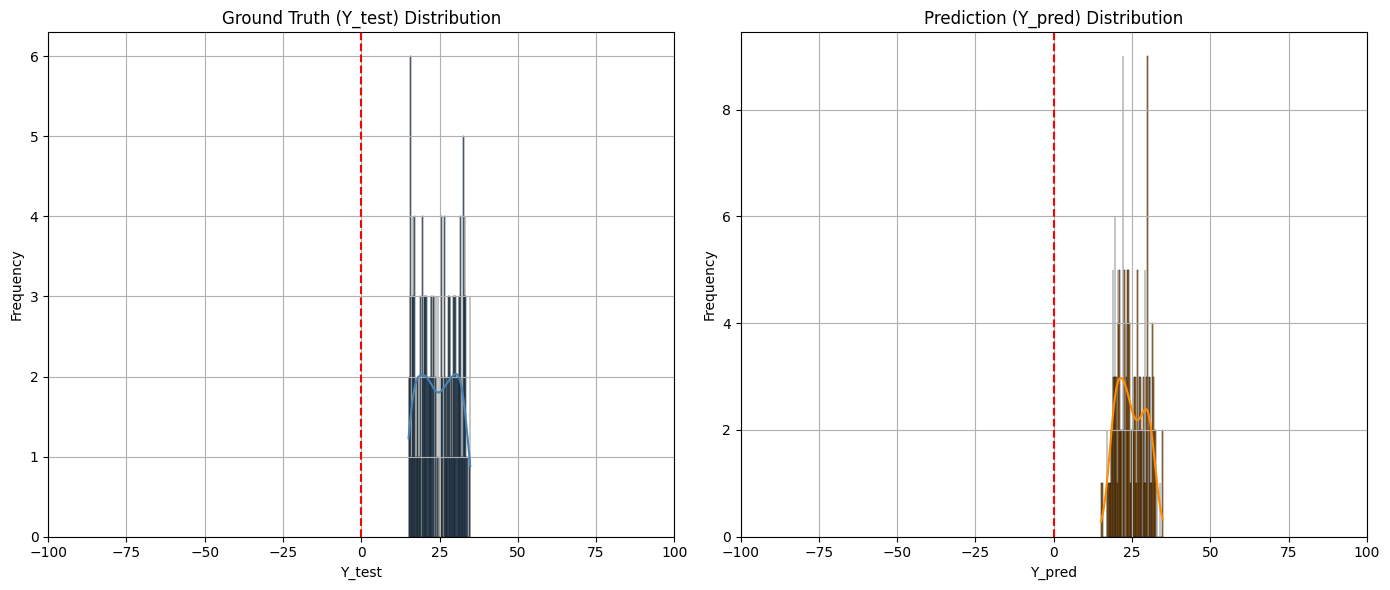

In [24]:
plt.figure(figsize=(14, 6))

# Subplot 1: Ground truth
plt.subplot(1, 2, 1)
sns.histplot(np.asarray(y_test_orig).ravel(), kde=True, bins=100, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Ground Truth (Y_test) Distribution")
plt.xlabel("Y_test")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-100, 100)

# Subplot 2: Prediction
plt.subplot(1, 2, 2)
sns.histplot( np.asarray(y_pred_orig).ravel(), kde=True, bins=100, color='darkorange', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Prediction (Y_pred) Distribution")
plt.xlabel("Y_pred")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-100, 100)

plt.tight_layout()
plt.show()

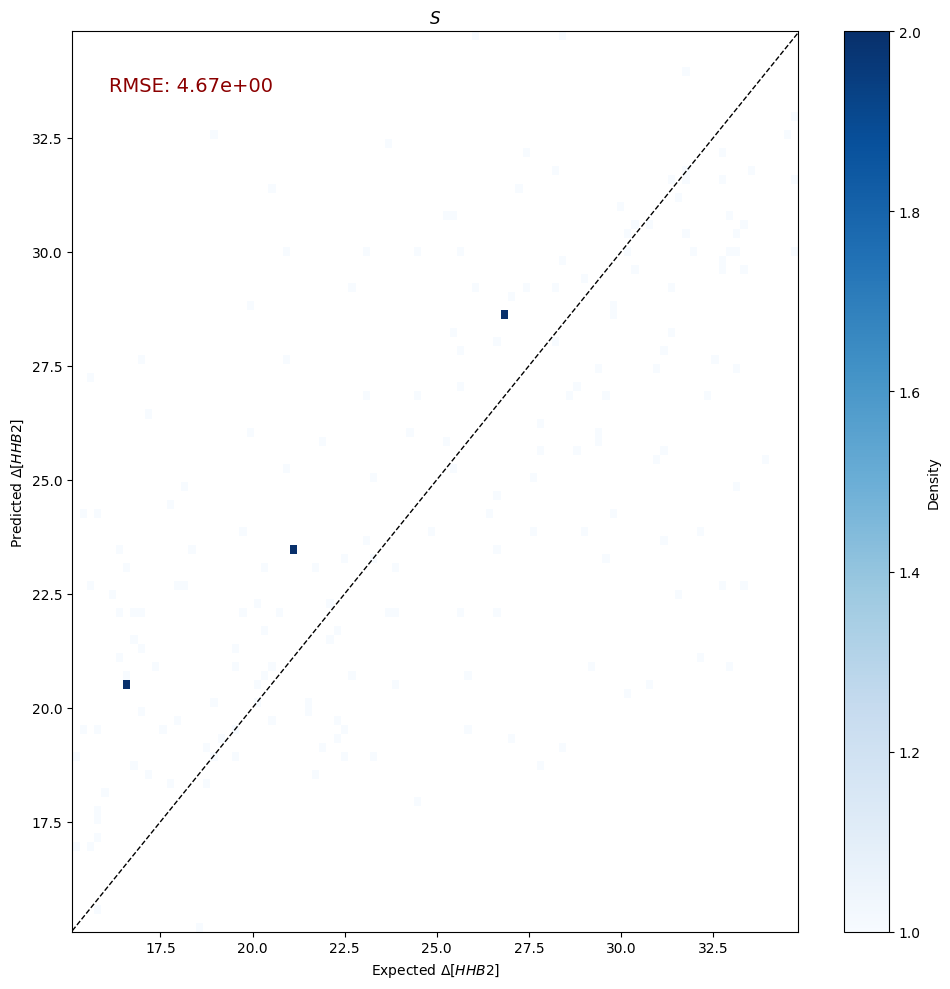

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Ensure y_true and y_pred are 1D numpy arrays
y_true = np.asarray(y_test_orig).ravel()
y_pred =np.asarray(y_pred_orig).ravel()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Plot
plt.figure(figsize=(10, 10))
plt.hist2d(y_true, y_pred, bins=100, cmap='Blues', cmin=1)

# Plot identity line
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)],
         'k--', lw=1)

# Labels and title
plt.xlabel('Expected $\Delta[HHB2]$')
plt.ylabel('Predicted $\Delta[HHB2]$')
plt.title(r'$S$')

# Annotate RMSE
plt.text(0.05, 0.95, f'RMSE: {rmse:.2e}', color='darkred',
         fontsize=14, transform=plt.gca().transAxes, va='top')

plt.colorbar(label='Density')
plt.tight_layout()
plt.show()

In [26]:
# Small epsilon to avoid division by zero
eps = 1e-8

# Relative error (%)
relative_error = (y_pred - y_true) / (y_true + eps) * 100
absolute_relative_error = np.abs(relative_error)

# Compute metrics
mre = np.mean(relative_error)
mape = np.mean(absolute_relative_error)

# Print
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

Mean Absolute Percentage Error (MAPE): 15.7719%
